* 2018-12-19 @Huang: based on Italy's "variables_derivation"

In [1]:
# impirt important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None  # show all columns

In [2]:
# read data
airline_data = pd.read_csv('../../data/dataset/airline.csv')
# cache_map_data = pd.read_csv('../../data/dataset/cache_map.csv')
group_data = pd.read_csv('../../data/dataset/group.csv')
order_data = pd.read_csv('../../data/dataset/order.csv')
day_schedule_data = pd.read_csv('../../data/dataset/day_schedule.csv')

#
column_names = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 
              'Altitude', 'Timezone', 'DST', 'TZ', 'Type','Source']
df_airport = pd.read_csv('../../data/airport.csv', names=column_names) #ref: https://openflights.org/data.html#airport

# test and train data
train_data = pd.read_csv('../../data/training-set.csv')
test_data = pd.read_csv('../../data/testing-set.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 處理訂單變數

In [3]:
order_data['order_date_dt'] = pd.to_datetime(order_data.order_date, format='%d-%b-%y') # ref: http://strftime.org/
order_data['order_year'] = order_data.order_date_dt.dt.year
order_data['order_month'] = order_data.order_date_dt.dt.month
order_data['order_day'] = order_data.order_date_dt.dt.day
order_data['order_dayofyear'] = order_data.order_date_dt.dt.dayofyear
order_data['order_weekday'] = order_data.order_date_dt.dt.dayofweek # 0=Mon, 6=Sun
order_data['unit']=order_data.unit.str.replace('unit_value_', '')
order_data['source_1']=order_data.source_1.str.replace('src1_value_', '')
order_data['source_2']=order_data.source_2.str.replace('src2_value_', '')
order_data['group_id'] = order_data['group_id'].apply(str)

### 處理group變數

In [4]:
group_data['sub_line'] = group_data.sub_line.str.replace('subline_value_','')
group_data['area'] = group_data.area.str.replace('area_value_','')
group_data['begin_date_dt'] = pd.to_datetime(group_data.begin_date, format='%d-%b-%y')
group_data['begin_year'] = group_data.begin_date_dt.dt.year
group_data['begin_month'] = group_data.begin_date_dt.dt.month
group_data['begin_day'] = group_data.begin_date_dt.dt.day
group_data['begin_dayofyear'] = group_data.begin_date_dt.dt.dayofyear
group_data['begin_weekday'] = group_data.begin_date_dt.dt.dayofweek # 0=Mon, 6=Sun
group_data['end_date_dt'] = group_data.begin_date_dt + group_data['days'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
group_data['end_year'] = group_data.end_date_dt.dt.year
group_data['end_month'] = group_data.end_date_dt.dt.month
group_data['end_day'] = group_data.end_date_dt.dt.day
group_data['end_dayofyear'] = group_data.end_date_dt.dt.dayofyear
group_data['end_weekday'] = group_data.end_date_dt.dt.dayofweek # 0=Mon, 6=Sun

### 處理航班變數

In [5]:
#
airline_data['dst_airport'] = airline_data.dst_airport.str.replace('([A-Z]+) ([^A-Z]+)','\\1')
airline_data['src_airport'] = airline_data.src_airport.str.replace('([A-Z]+) ([^A-Z]+)','\\1')
airline_data['go_back'] = airline_data.go_back.str.replace('去程', 'go')
airline_data['go_back'] = airline_data.go_back.str.replace('回程', 'back')

# unify time, compute the travel time for each routes
airline_data['src_IATA'] = airline_data.src_airport.str.replace('([A-Z]+) ([^A-Z])+', '\\1')
airline_data['dst_IATA'] = airline_data.dst_airport.str.replace('([A-Z]+) ([^A-Z])+', '\\1')
tmp = pd.merge(airline_data, df_airport[['IATA','TZ']], left_on='src_IATA', right_on='IATA', how='left')
airline_data = tmp.rename(index=str, columns={'TZ':'src_TZ'}).drop(['IATA'], axis=1)
tmp = pd.merge(airline_data, df_airport[['IATA','TZ']], left_on='dst_IATA', right_on='IATA', how='left')
airline_data = tmp.rename(index=str, columns={'TZ':'dst_TZ'}).drop(['IATA'], axis=1)
airline_data['fly_time'] = pd.to_datetime(airline_data.fly_time, format='%Y/%m/%d %H:%M')
airline_data['arrive_time'] = pd.to_datetime(airline_data.arrive_time, format='%Y/%m/%d %H:%M')

def src_time_utc(x):
    try: 
        res = x['fly_time'].tz_localize(x['src_TZ']).tz_convert('UTC')
    except:
        res = None # 因為有些機場沒有抓到對應time-zone (可後續用手動補)
    return res

def dst_time_utc(x):
    try:
        res = x['arrive_time'].tz_localize(x['dst_TZ']).tz_convert('UTC')
    except:
        res = None
    return res

airline_data['arrive_time_utc'] = airline_data.apply(dst_time_utc, axis=1)
airline_data['fly_time_utc'] = airline_data.apply(src_time_utc, axis=1)
airline_data['traval_time'] = airline_data['arrive_time_utc'] - airline_data['fly_time_utc']

# derive number of routes for each group
go_route_num=airline_data[airline_data['go_back']=='go'].groupby('group_id')['dst_airport'].nunique()
back_route_num=airline_data[airline_data['go_back']=='back'].groupby('group_id')['dst_airport'].nunique()
df_route_num = pd.merge(go_route_num.to_frame('go_route_num'), back_route_num.to_frame('back_route_num'), left_index=True, right_index=True,how='outer')

# derive total travel time for each group
def mean(x):
    return x.sum()/x.count()

#
tmp=airline_data[airline_data.go_back=='go'].groupby(['group_id','dst_IATA'])['traval_time'].apply(mean)
#print(tmp.head())
go_time=tmp.to_frame().groupby(['group_id'])['traval_time'].sum()

#
tmp=airline_data[airline_data.go_back=='back'].groupby(['group_id','dst_IATA'])['traval_time'].apply(mean)
#print(tmp.head())
back_time=tmp.to_frame().groupby(['group_id'])['traval_time'].sum()

#
df_total_travel_time = pd.merge(go_time.to_frame('go_time'), back_time.to_frame('back_time'), left_index=True, right_index=True,how='outer')

In [6]:
# merge following two df with order_id on group_id 
print(df_total_travel_time.head())
print(df_route_num.head())

                                  go_time back_time
group_id                                           
00018d44e062e3db9dc0460a5c78f0ee 04:25:00  04:50:00
000858b64a52e724cd008bbfe2fc8cdd 02:15:00  02:35:00
000a91291573c4b8b44300de8136b86b 03:15:00  03:00:00
000d1cccbb593a8210840a43457aa5e2 02:25:00  02:20:00
0012d75d4bfe483a414b09b50b548f58 02:30:00  03:00:00
                                  go_route_num  back_route_num
group_id                                                      
00018d44e062e3db9dc0460a5c78f0ee           1.0             1.0
000858b64a52e724cd008bbfe2fc8cdd           1.0             1.0
000a91291573c4b8b44300de8136b86b           1.0             1.0
000d1cccbb593a8210840a43457aa5e2           1.0             1.0
0012d75d4bfe483a414b09b50b548f58           1.0             1.0


In [7]:
df_route_num.describe()

,go_route_num,back_route_num
count,48795.000000,48755.000000
mean,1.069905,1.067501
std,0.275391,0.268732
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,5.000000,4.000000


In [8]:
df_total_travel_time.describe() 

,go_time,back_time
count,48795,48755
mean,0 days 05:11:58.263756,0 days 05:02:34.065429
std,1 days 15:56:56.208220,0 days 04:03:28.856158
min,-1 days +08:55:00,-1 days +02:40:00
25%,0 days 02:30:00,0 days 02:40:00
50%,0 days 03:10:00,0 days 03:20:00
75%,0 days 04:35:00,0 days 04:50:00
max,365 days 17:40:00,1 days 15:25:00


In [9]:
#資料型別處理
df_total_travel_time = df_total_travel_time.reset_index()
df_total_travel_time['group_id'] = df_total_travel_time.group_id.apply(str)
df_route_num = df_route_num.reset_index()
df_route_num['group_id'] = df_route_num.group_id.apply(str)
tmp = airline_data[airline_data['go_back']=='go'].sort_values(by='fly_time')
df_airline_fly_time = tmp.groupby('group_id').first().reset_index()[['group_id', 'fly_time']]
df_airline_fly_time['group_id'] = df_airline_fly_time.group_id.apply(str)

> need to fix the cross year trip

In [23]:
tmp = pd.merge(order_data, df_total_travel_time, on='group_id', how='left')
tmp = pd.merge(tmp, df_route_num, on='group_id', how='left')
tmp = pd.merge(tmp, df_airline_fly_time, on='group_id', how='left')
df_predictors = pd.merge(tmp, group_data.drop(['product_name','promotion_prog'], axis=1), on='group_id', how='left').drop('order_date', axis=1)
df_predictors['date_diff_order_begin'] = df_predictors.fly_time - df_predictors.order_date_dt  

In [24]:
df_predictors.head()

,order_id,group_id,source_1,source_2,unit,people_amount,order_date_dt,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,fly_time,sub_line,area,days,begin_date,price,begin_date_dt,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_date_dt,end_year,end_month,end_day,end_dayofyear,end_weekday,date_diff_order_begin
0,136100,63695,1,1,1,2,2017-01-05,2017,1,5,5,3,08:45:00,15:30:00,1.0,1.0,2017-03-22 23:30:00,1,1,12.0,22-Mar-17,106900.0,2017-03-22,2017,3,22,81,2,2017-04-03,2017,4,3,93,0,76 days 23:30:00
1,140370,63695,1,1,2,1,2016-11-09,2016,11,9,314,2,08:45:00,15:30:00,1.0,1.0,2017-03-22 23:30:00,1,1,12.0,22-Mar-17,106900.0,2017-03-22,2017,3,22,81,2,2017-04-03,2017,4,3,93,0,133 days 23:30:00
2,211009,63695,1,1,3,2,2017-01-20,2017,1,20,20,4,08:45:00,15:30:00,1.0,1.0,2017-03-22 23:30:00,1,1,12.0,22-Mar-17,106900.0,2017-03-22,2017,3,22,81,2,2017-04-03,2017,4,3,93,0,61 days 23:30:00
3,41571,53481,1,1,4,4,2017-03-14,2017,3,14,73,1,09:45:00,14:05:00,1.0,1.0,2017-05-17 23:00:00,1,1,12.0,17-May-17,112900.0,2017-05-17,2017,5,17,137,2,2017-05-29,2017,5,29,149,0,64 days 23:00:00
4,64125,53481,2,1,5,1,2017-03-27,2017,3,27,86,0,09:45:00,14:05:00,1.0,1.0,2017-05-17 23:00:00,1,1,12.0,17-May-17,112900.0,2017-05-17,2017,5,17,137,2,2017-05-29,2017,5,29,149,0,51 days 23:00:00


> date_diff_order_begin 可能要trim掉太大的值，奇怪的數值和跨年有關

In [25]:
# 把時間轉單位轉成總共幾分
df_predictors.go_time = df_predictors.go_time.apply(lambda x: x.total_seconds()/60) 
df_predictors.back_time = df_predictors.back_time.apply(lambda x: x.total_seconds()/60) 
df_predictors.date_diff_order_begin = df_predictors.date_diff_order_begin.apply(lambda x: x.total_seconds()/60) 

In [26]:
df_predictors = df_predictors.drop(['order_date_dt','begin_date_dt','end_date_dt','fly_time','begin_date'], axis=1)

In [27]:
df_predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396915 entries, 0 to 396914
Data columns (total 30 columns):
order_id                 396915 non-null object
group_id                 396915 non-null object
source_1                 396915 non-null object
source_2                 396915 non-null object
unit                     396915 non-null int64
people_amount            396915 non-null int64
order_year               396915 non-null int64
order_month              396915 non-null int64
order_day                396915 non-null int64
order_dayofyear          396915 non-null int64
order_weekday            396915 non-null int64
go_time                  395973 non-null float64
back_time                395750 non-null float64
go_route_num             395973 non-null float64
back_route_num           395750 non-null float64
sub_line                 396915 non-null object
area                     396915 non-null object
days                     396915 non-null float64
price                    39

In [28]:
df_predictors.head()

,order_id,group_id,source_1,source_2,unit,people_amount,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,sub_line,area,days,price,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_year,end_month,end_day,end_dayofyear,end_weekday,date_diff_order_begin
0,136100,63695,1,1,1,2,2017,1,5,5,3,525.0,930.0,1.0,1.0,1,1,12.0,106900.0,2017,3,22,81,2,2017,4,3,93,0,110850.0
1,140370,63695,1,1,2,1,2016,11,9,314,2,525.0,930.0,1.0,1.0,1,1,12.0,106900.0,2017,3,22,81,2,2017,4,3,93,0,192930.0
2,211009,63695,1,1,3,2,2017,1,20,20,4,525.0,930.0,1.0,1.0,1,1,12.0,106900.0,2017,3,22,81,2,2017,4,3,93,0,89250.0
3,41571,53481,1,1,4,4,2017,3,14,73,1,585.0,845.0,1.0,1.0,1,1,12.0,112900.0,2017,5,17,137,2,2017,5,29,149,0,93540.0
4,64125,53481,2,1,5,1,2017,3,27,86,0,585.0,845.0,1.0,1.0,1,1,12.0,112900.0,2017,5,17,137,2,2017,5,29,149,0,74820.0


In [83]:
df_predictors.isna().sum(axis=0), df_predictors.shape

(order_id                    0
 group_id                    0
 source_1                    0
 source_2                    0
 unit                        0
 people_amount               0
 order_year                  0
 order_month                 0
 order_day                   0
 order_dayofyear             0
 order_weekday               0
 go_time                   942
 back_time                1165
 go_route_num              942
 back_route_num           1165
 sub_line                    0
 area                        0
 days                        0
 price                       0
 begin_year                  0
 begin_month                 0
 begin_day                   0
 begin_dayofyear             0
 begin_weekday               0
 end_year                    0
 end_month                   0
 end_day                     0
 end_dayofyear               0
 end_weekday                 0
 date_diff_order_begin     942
 dtype: int64, (396915, 30))

In [ ]:
source_1                 396915 non-null object
source_2                 396915 non-null object
 

### check and separate the final dataset

In [29]:
df_predictors.shape

(396915, 30)

In [163]:
df_predictors['source_1'] = df_predictors['source_1'].astype(int)
df_predictors['source_2'] = df_predictors['source_2'].astype(int)

train_data['order_id'] = train_data['order_id'].astype(str)
test_data['order_id'] = test_data['order_id'].astype(str)
df_predictors['order_id'] = df_predictors['order_id'].astype(str)

# seperate into train and test features
train_features = pd.merge(df_predictors, train_data, on='order_id', how='inner') 
test_features = pd.merge(df_predictors, test_data, on='order_id', how='inner')


# make category vars into floats
one_hot_encoded_training_predictors = pd.get_dummies(train_features[['unit','area','sub_line']].astype(str))
one_hot_encoded_test_predictors = pd.get_dummies(test_features[['unit','area','sub_line']].astype(str))
final_train_c, final_test_c = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left', axis=1)
final_train_c, final_test_c = final_train_c.fillna(0), final_test_c.fillna(0)
from sklearn.linear_model import RidgeCV
clf_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(final_train_c, train_features.deal_or_not)
train_ridge_score = clf_ridge.predict(final_train_c) 
test_ridge_score = clf_ridge.predict(final_test_c) 

In [205]:
# make category vars into floats
from sklearn.linear_model import RidgeCV
one_hot_encoded_training_predictors1 = pd.get_dummies(train_features[['unit']].astype(str))
one_hot_encoded_test_predictors1 = pd.get_dummies(test_features[['unit']].astype(str))
final_train_c1, final_test_c1 = one_hot_encoded_training_predictors1.align(one_hot_encoded_test_predictors1,
                                                                    join='left', axis=1)
final_train_c1, final_test_c1 = final_train_c1.fillna(0), final_test_c1.fillna(0)
clf_ridge1 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(final_train_c1, train_features.deal_or_not)
train_ridge_score1 = clf_ridge1.predict(final_train_c1) 
test_ridge_score1 = clf_ridge1.predict(final_test_c1) 

#
one_hot_encoded_training_predictors2 = pd.get_dummies(train_features[['area']].astype(str))
one_hot_encoded_test_predictors2 = pd.get_dummies(test_features[['area']].astype(str))
final_train_c2, final_test_c2 = one_hot_encoded_training_predictors2.align(one_hot_encoded_test_predictors2,
                                                                    join='left', axis=1)
final_train_c2, final_test_c2 = final_train_c2.fillna(0), final_test_c2.fillna(0)
clf_ridge2 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(final_train_c2, train_features.deal_or_not)
train_ridge_score2 = clf_ridge2.predict(final_train_c2) 
test_ridge_score2 = clf_ridge2.predict(final_test_c2) 

#
one_hot_encoded_training_predictors3 = pd.get_dummies(train_features[['sub_line']].astype(str))
one_hot_encoded_test_predictors3 = pd.get_dummies(test_features[['sub_line']].astype(str))
final_train_c3, final_test_c3 = one_hot_encoded_training_predictors3.align(one_hot_encoded_test_predictors3,
                                                                    join='left', axis=1)
final_train_c3, final_test_c3 = final_train_c3.fillna(0), final_test_c3.fillna(0)
clf_ridge3 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(final_train_c3, train_features.deal_or_not)
train_ridge_score3 = clf_ridge3.predict(final_train_c3) 
test_ridge_score3 = clf_ridge3.predict(final_test_c3)



In [210]:
train_features_final = train_features.drop(['order_id','group_id','unit','area','sub_line','deal_or_not'], axis=1)
train_features_final['ridge1'] = train_ridge_score1
train_features_final['ridge2'] = train_ridge_score2
train_features_final['ridge3'] = train_ridge_score3

train_Y = train_features['deal_or_not'] ##
print(train_features_final.shape)
test_features_final = test_features.drop(['order_id','group_id','unit','area','sub_line'], axis=1)
test_features_final = test_features_final.iloc[:,:len(test_features_final.keys())-1]
test_features_final['ridge1'] = test_ridge_score1
test_features_final['ridge2'] = test_ridge_score2
test_features_final['ridge3'] = test_ridge_score3
print(test_features_final.shape)

(297020, 28)
(99895, 28)


In [211]:
# missing data imputation
train_features_final = train_features_final.fillna(0)
test_features_final = test_features_final.fillna(0)

In [212]:
X_train, X_cv, y_train, y_cv = train_test_split(train_features_final,
                                                    train_Y,
                                                    test_size = 0.2,
                                                    random_state = 0)


xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [213]:
xgb_predictions = xgb_model.predict(X_cv)
print(len(y_cv), len(xgb_predictions))

59404 59404


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Optimized Model
------
Final accuracy score on the testing data: 0.8234
Final precision score on the testing data: 0.9485
Final recall score on the testing data: 0.1001
Final F-score on the testing data: 0.3519


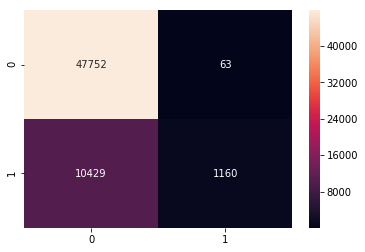

In [214]:
# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_cv, xgb_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_cv, xgb_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_cv, xgb_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_cv, xgb_predictions, beta = 0.5)))

from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_cv, xgb_predictions), annot = True, fmt = '')


Optimized Model
------
Final accuracy score on the testing data: 0.8234
Final precision score on the testing data: 0.9384
Final recall score on the testing data: 0.1012
Final F-score on the testing data: 0.3535


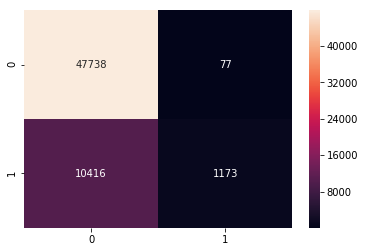

In [203]:
# Report the before-and-afterscores (1st ridge xgboost)
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_cv, xgb_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_cv, xgb_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_cv, xgb_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_cv, xgb_predictions, beta = 0.5)))

from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_cv, xgb_predictions), annot = True, fmt = '')

In [176]:
submission_Y = xgb_predictions_submission = xgb_model.predict(test_features_final)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [197]:
print('{}/{} of dealed order'.format(submission_Y.sum(), len(submission_Y) ))

2315/99895 of dealed order


In [198]:
df_submission = test_data.iloc[:,:1].copy()
df_submission['deal_or_not'] = submission_Y
df_submission.head()

,order_id,deal_or_not
0,3240332c374b21f9882f899f13b71308,0
1,bf0c0a570b848499180b9dbd49a12d76,0
2,0db30b8d4770f5145d932133e54a35a1,1
3,d3eaffe7c163fabadd8bff4aa28ee1c1,0
4,fefb2b6d55df4474e4826ddac2a97465,0


In [199]:
df_submission.to_csv('xgb_results.csv', index=False)



In [180]:
len(submission_Y)

99895

In [181]:
2315/99895

0.02317433304970219

In [183]:
rf_results=pd.read_csv('../HuangKY/rf_results.csv')

In [185]:
rf_results.deal_or_not.sum()

2144

In [217]:
train_features_final.describe()

,source_1,source_2,people_amount,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,days,price,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_year,end_month,end_day,end_dayofyear,end_weekday,date_diff_order_begin,ridge1,ridge2,ridge3
count,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.00000,297020.000000,297020.000000,297020.000000,297020.0,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000,297020.000000
mean,1.342697,1.514245,3.204232,2016.854946,6.453751,15.287412,180.479490,2.393721,346.340693,345.654205,1.08220,1.079028,6.539226,38229.697465,2017.0,6.410562,16.424150,180.190630,3.138476,2017.020372,6.415905,15.369083,179.293943,2.879745,76603.920985,0.197253,0.197253,0.197253
std,0.522653,0.977495,3.177820,0.352156,3.365564,8.590166,103.614357,1.773984,290.651801,268.835472,0.30642,0.301624,2.192743,20616.239184,0.0,3.413493,9.014846,103.304596,1.951427,0.141271,3.366803,9.190652,103.217177,2.019927,52209.333819,0.087281,0.028510,0.016542
min,1.000000,1.000000,1.000000,2016.000000,1.000000,1.000000,1.000000,0.000000,-905.000000,-1280.000000,0.00000,0.000000,2.000000,3000.000000,2017.0,1.000000,1.000000,1.000000,0.000000,2017.000000,1.000000,1.000000,1.000000,0.000000,-487615.000000,0.000110,0.001026,0.009906
25%,1.000000,1.000000,2.000000,2017.000000,4.000000,8.000000,92.000000,1.000000,160.000000,170.000000,1.00000,1.000000,5.000000,23900.000000,2017.0,4.000000,8.000000,91.000000,1.000000,2017.000000,4.000000,7.000000,93.000000,1.000000,36543.750000,0.167899,0.176761,0.185873
50%,1.000000,1.000000,2.000000,2017.000000,6.000000,15.000000,177.000000,2.000000,205.000000,220.000000,1.00000,1.000000,5.000000,33900.000000,2017.0,6.000000,17.000000,178.000000,3.000000,2017.000000,6.000000,15.000000,179.000000,3.000000,65220.000000,0.176392,0.203122,0.202885
75%,2.000000,1.000000,4.000000,2017.000000,9.000000,22.000000,270.000000,4.000000,535.000000,540.000000,1.00000,1.000000,8.000000,43900.000000,2017.0,9.000000,24.000000,273.000000,5.000000,2017.000000,9.000000,24.000000,271.000000,5.000000,105871.250000,0.199837,0.212843,0.207282
max,3.000000,4.000000,50.000000,2017.000000,12.000000,31.000000,366.000000,6.000000,2315.000000,2365.000000,3.00000,4.000000,17.000000,222900.000000,2017.0,12.000000,31.000000,365.000000,6.000000,2018.000000,12.000000,31.000000,365.000000,6.000000,989265.000000,0.930141,0.393474,0.398528


In [218]:
test_features_final[['go_time','back_time','date_diff_order_begin',]].describe()

,go_time,back_time,date_diff_order_begin
count,99895.000000,99895.000000,9.989500e+04
mean,471.731708,371.829691,8.551050e+04
std,6872.013489,280.374131,6.021623e+04
min,0.000000,0.000000,-4.482850e+05
25%,150.000000,165.000000,4.031000e+04
50%,205.000000,220.000000,7.320000e+04
75%,765.000000,705.000000,1.204650e+05
max,526660.000000,2200.000000,1.212945e+06


In [232]:
test_features_final[train_features_final['date_diff_order_begin']<0].shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(9, 28)

In [98]:
# from sklearn.preprocessing import OneHotEncoder
# dummy_coder = OneHotEncoder(handle_unknown='ignore')
# dummy_coder.fit(df_predictors[['unit','area']])
# dummy_coder.transform(df_predictors[['unit','area']].head()).toarray()

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='ignore', n_values='auto', sparse=True)

In [128]:
one_hot_encoded_training_predictors = pd.get_dummies(train_features[['unit','area','sub_line']].astype(str))
one_hot_encoded_test_predictors = pd.get_dummies(test_features[['unit','area','sub_line']].astype(str))
final_train_c, final_test_c = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left', axis=1)
final_train_c, final_test_c = final_train_c.fillna(0), final_test_c.fillna(0)

In [118]:
len(train_features.order_id), test_data.shape

(297020, (99895, 2))

In [123]:
train_features.deal_or_not.sum()

58588

In [129]:
from sklearn.linear_model import RidgeCV
clf_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(final_train_c, train_features.deal_or_not)
train_ridge_score = clf_ridge.predict(final_train_c) 
test_ridge_score = clf_ridge.predict(final_test_c) 

In [167]:
# df_cate_dummy = pd.get_dummies(df_predictors[['unit','area']].astype(str))


In [90]:
train_features[['unit','area']].head()

,unit,area
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [33]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99895 entries, 0 to 99894
Data columns (total 31 columns):
order_id                 99895 non-null object
group_id                 99895 non-null object
source_1                 99895 non-null object
source_2                 99895 non-null object
unit                     99895 non-null int64
people_amount            99895 non-null int64
order_year               99895 non-null int64
order_month              99895 non-null int64
order_day                99895 non-null int64
order_dayofyear          99895 non-null int64
order_weekday            99895 non-null int64
go_time                  99736 non-null float64
back_time                99752 non-null float64
go_route_num             99736 non-null float64
back_route_num           99752 non-null float64
sub_line                 99895 non-null object
area                     99895 non-null object
days                     99895 non-null float64
price                    99895 non-null float64

In [35]:
train_features = train_features.dropna()  # TODO:  try to save more data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

train_features_y = train_features['deal_or_not']
train_features_X = train_features.drop(['order_id', 'group_id', 'deal_or_not'], axis=1)
# TODO: make dummy variavbles!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [37]:
train_features_X.head(10)

,source_1,source_2,unit,people_amount,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,sub_line,area,days,price,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_year,end_month,end_day,end_dayofyear,end_weekday,date_diff_order_begin
0,1,1,1,2,2017,1,5,5,3,525.0,930.0,1.0,1.0,1,1,12.0,106900.0,2017,3,22,81,2,2017,4,3,93,0,110850.0
1,1,1,2,1,2016,11,9,314,2,525.0,930.0,1.0,1.0,1,1,12.0,106900.0,2017,3,22,81,2,2017,4,3,93,0,192930.0
2,1,1,3,2,2017,1,20,20,4,525.0,930.0,1.0,1.0,1,1,12.0,106900.0,2017,3,22,81,2,2017,4,3,93,0,89250.0
3,1,1,4,4,2017,3,14,73,1,585.0,845.0,1.0,1.0,1,1,12.0,112900.0,2017,5,17,137,2,2017,5,29,149,0,93540.0
4,2,1,5,1,2017,3,27,86,0,585.0,845.0,1.0,1.0,1,1,12.0,112900.0,2017,5,17,137,2,2017,5,29,149,0,74820.0
5,2,2,6,2,2017,4,19,109,2,585.0,845.0,1.0,1.0,1,1,12.0,112900.0,2017,5,17,137,2,2017,5,29,149,0,41700.0
6,2,2,6,2,2017,4,19,109,2,585.0,845.0,1.0,1.0,1,1,12.0,112900.0,2017,5,17,137,2,2017,5,29,149,0,41700.0
7,1,1,7,6,2017,1,20,20,4,525.0,930.0,1.0,1.0,1,1,12.0,115900.0,2017,6,21,172,2,2017,7,3,184,0,220290.0
8,2,3,6,2,2017,5,8,128,0,525.0,930.0,1.0,1.0,1,1,12.0,115900.0,2017,6,21,172,2,2017,7,3,184,0,64770.0
9,1,1,8,2,2017,5,8,128,0,525.0,930.0,1.0,1.0,1,1,12.0,115900.0,2017,6,21,172,2,2017,7,3,184,0,64770.0


In [38]:
train_features_y.value_counts()

0    237521
1     58477
Name: deal_or_not, dtype: int64

In [24]:
'''
## 未来 TODO

原始資料  group_id' == '63695'  是有去回程時間
但最後的加工&merge結果　變成null
我們之後有時間可以研究看看是哪個還節
'''

"\n## 未来 TODO\n\n原始資料  group_id' == '63695'  是有去回程時間\n但最後的加工&merge結果\u3000變成null\n我們之後有時間可以研究看看是哪個還節\n"

In [25]:
'''
TODO: 

scaling

'''

'\nTODO: \n\nscaling\n\n'

## Model: XgBoost

In [47]:
import xgboost as xgb

In [ ]:
# # dummy化
# df_predictors_dummy = pd.get_dummies(df_predictors)


# # seperate into train and test features
# train_features_dummy = pd.merge(df_predictors_dummy, train_data, on='order_id', how='inner') 
# test_features_dummy = pd.merge(df_predictors_dummy, test_data, on='order_id', how='inner')


# # train features: drop nulls
# train_features_dummy = train_features_dummy.dropna()  # TODO:  try to save more data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# train_features_y_dummy = train_features_dummy['deal_or_not']
# train_features_X_dummy = train_features_dummy.drop(['order_id', 'group_id', 'begin_date', 'deal_or_not'], axis=1)


# # test features: fill nulls with 0 
# test_features_X_dummy = test_features_dummy.fillna(0)   ## TODO:  fillna考慮 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# test_features_X_dummy = test_features_dummy.drop(['order_id', 'group_id', 'begin_date', ' deal_or_not'], axis=1)


# X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(train_features_dummy, 
#                                                     train_features_y_dummy, 
#                                                     test_size = 0.33, 
#                                                     random_state = 0)


In [ ]:
# make all categorical data astype int 
X_train['source_1'] = X_train['source_1'].astype(int)
X_train['source_2'] = X_train['source_2'].astype(int)
X_test['source_1'] = X_test['source_1'].astype(int)
X_test['source_2'] = X_test['source_2'].astype(int)
# ignore the warning!

In [67]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [76]:
xgb_predictions = xgb_model.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Optimized Model
------
Final accuracy score on the testing data: 0.8181
Final precision score on the testing data: 0.9517
Final recall score on the testing data: 0.0904
Final F-score on the testing data: 0.3276


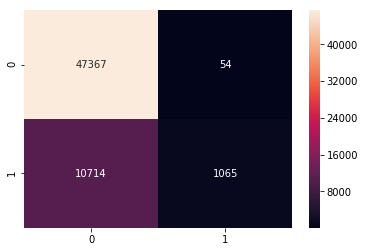

In [79]:
# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, xgb_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, xgb_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, xgb_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, xgb_predictions, beta = 0.5)))



from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot = True, fmt = '')


Optimized Model
------
Final accuracy score on the testing data: 0.8263
Final precision score on the testing data: 0.9514
Final recall score on the testing data: 0.1024
Final F-score on the testing data: 0.3579


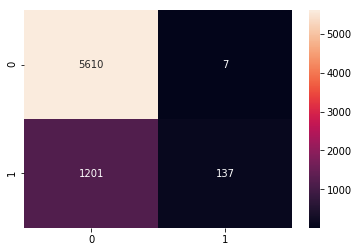

In [91]:
# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_dummy, xgb_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test_dummy, xgb_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test_dummy, xgb_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_dummy, xgb_predictions, beta = 0.5)))



from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_test_dummy, xgb_predictions), annot = True, fmt = '')

In [ ]:
xgb_results = pd.DataFrame(data={'order_id': test_features['order_id'], 'deal_or_not' : xgb_model.predict(test_features_X_dummy)})
xgb_results.to_csv('xgb_results.csv', index=False)